In [1]:
from pytorch_grad_cam import GradCAM
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import utils.classifier_utils as classifier_utils

import os
import random
from PIL import Image
import numpy as np
import copy
import yaml
import matplotlib.pyplot as plt
import pickle

In [2]:
use_cuda = True
resnet_config = 'configs/resnet_config.yaml'
inception_config = 'configs/inception_config.yaml'
vit_config = 'configs/vit_config.yaml'

with open(inception_config) as f:
    config = yaml.safe_load(f)

model = classifier_utils.loadModel(config)

In [3]:
##### Load random images and save in pickle files

# type_img = ["nsfw", "sfw"]
# base_folder = "/home/neelesh/research-project-security-sheriffs/dataset/train/"
# num_images = 16
# nsfw_imgs_list = []
# sfw_imgs_list = []

# nsfw_folder = os.path.join(base_folder, type_img[0])
# nsfw_imgs_list = os.listdir(nsfw_folder)
# nsfw_imgs_list = [os.path.join(nsfw_folder, nsfw_img) for nsfw_img in nsfw_imgs_list]
# nsfw_imgs_list = random.sample(nsfw_imgs_list, num_images)

# sfw_folder = os.path.join(base_folder, type_img[1])
# sfw_imgs_list = os.listdir(sfw_folder)
# sfw_imgs_list = [os.path.join(sfw_folder, sfw_img) for sfw_img in sfw_imgs_list]
# sfw_imgs_list = random.sample(sfw_imgs_list, num_images)

# print(nsfw_imgs_list)
# print(sfw_imgs_list)

# with open("dataset_log/nsfw_list.pkl", "wb") as file:
#     pickle.dump(nsfw_imgs_list, file)

# with open("dataset_log/sfw_list.pkl", "wb") as file:
#     pickle.dump(sfw_imgs_list, file)

In [34]:
img_type = "sfw"
# img_type = "nsfw"

if img_type == "sfw":
    with open("dataset_log/sfw_list.pkl", "rb") as file:
        imgs_list = pickle.load(file)

if img_type == "nsfw":
    with open("dataset_log/nsfw_list.pkl", "rb") as file:
        imgs_list = pickle.load(file)

print(imgs_list)

['/home/neelesh/research-project-security-sheriffs/dataset/train/sfw/WOMEN-Blouses_Shirts-id_00003658-01_7_additional.jpg', '/home/neelesh/research-project-security-sheriffs/dataset/train/sfw/WOMEN-Tees_Tanks-id_00007603-02_4_full.jpg', '/home/neelesh/research-project-security-sheriffs/dataset/train/sfw/MEN-Tees_Tanks-id_00007937-01_3_back.jpg', '/home/neelesh/research-project-security-sheriffs/dataset/train/sfw/WOMEN-Sweatshirts_Hoodies-id_00004574-01_7_additional.jpg', '/home/neelesh/research-project-security-sheriffs/dataset/train/sfw/WOMEN-Sweatshirts_Hoodies-id_00004317-01_2_side.jpg', '/home/neelesh/research-project-security-sheriffs/dataset/train/sfw/WOMEN-Tees_Tanks-id_00005602-02_3_back.jpg', '/home/neelesh/research-project-security-sheriffs/dataset/train/sfw/WOMEN-Jackets_Coats-id_00005502-04_7_additional.jpg', '/home/neelesh/research-project-security-sheriffs/dataset/train/sfw/WOMEN-Dresses-id_00002519-02_3_back.jpg', '/home/neelesh/research-project-security-sheriffs/dataset

In [35]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

inverse_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize])

In [36]:
input_tensors = []
original_imgs = []
img_names = []
with torch.no_grad():
    for img_name in imgs_list:
        img = Image.open(img_name).convert('RGB')
        img_name = img_name.split("/")[-1]
        img_names.append(img_name)

        original_img = copy.deepcopy(img)
        img = img.resize((224, 224))
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        original_imgs.append(img)
        
        tensor_img = transform(original_img)
        tensor_img = tensor_img.unsqueeze(0)
        input_tensors.append(tensor_img)

        output = model(tensor_img)
        y_pred = torch.round(torch.sigmoid(output))
        y_pred = y_pred.cpu().numpy()[0][0]
        print("Image - {} : {}".format(img_name, y_pred))

Image - WOMEN-Blouses_Shirts-id_00003658-01_7_additional.jpg : 1.0
Image - WOMEN-Tees_Tanks-id_00007603-02_4_full.jpg : 1.0
Image - MEN-Tees_Tanks-id_00007937-01_3_back.jpg : 1.0
Image - WOMEN-Sweatshirts_Hoodies-id_00004574-01_7_additional.jpg : 1.0
Image - WOMEN-Sweatshirts_Hoodies-id_00004317-01_2_side.jpg : 1.0
Image - WOMEN-Tees_Tanks-id_00005602-02_3_back.jpg : 1.0
Image - WOMEN-Jackets_Coats-id_00005502-04_7_additional.jpg : 1.0
Image - WOMEN-Dresses-id_00002519-02_3_back.jpg : 1.0
Image - WOMEN-Cardigans-id_00000833-02_3_back.jpg : 1.0
Image - WOMEN-Sweaters-id_00001749-03_7_additional.jpg : 1.0
Image - WOMEN-Blouses_Shirts-id_00000588-04_3_back.jpg : 1.0
Image - WOMEN-Tees_Tanks-id_00003558-11_2_side.jpg : 1.0
Image - WOMEN-Jackets_Coats-id_00006393-01_3_back.jpg : 1.0
Image - WOMEN-Dresses-id_00007769-07_1_front.jpg : 1.0
Image - WOMEN-Dresses-id_00005768-19_2_side.jpg : 1.0
Image - MEN-Sweatshirts_Hoodies-id_00003060-05_3_back.jpg : 1.0


In [37]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [38]:
grad_cam_imgs = []

output_dir = os.path.join("grad_cam_outputs", config['model'], img_type)
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

###### Target layers for VIT
# target_layers = [model.module.encoder.layers.encoder_layer_10.ln_1]

####### Target Layers for Resnet50
# target_layers = [model.module.layer4[-1].bn3]

####### Target Layers for Resnet34
# target_layers = [model.module.layer4[-2].bn2]

####### Target Layers for Resnet18
# target_layers = [model.module.layer4[-2]]

####### Target Layers for Inception
target_layers = [model.module.Mixed_7c.branch_pool.bn, model.module.Mixed_7c.branch3x3dbl_3b.bn]

if config['base'] == 'vit':
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True, reshape_transform=reshape_transform)
else:
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(0)]

for i in range(len(input_tensors)):

    index = i
    # print(input_tensors[2].shape)
    grayscale_cam = cam(input_tensor=input_tensors[index], targets=targets, eigen_smooth=True, aug_smooth=True)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(original_imgs[index], grayscale_cam, use_rgb=True)

    grad_output = Image.fromarray(visualization, 'RGB')
    grad_cam_imgs.append(grad_output)

    grad_output.save(os.path.join(output_dir, img_names[index]))

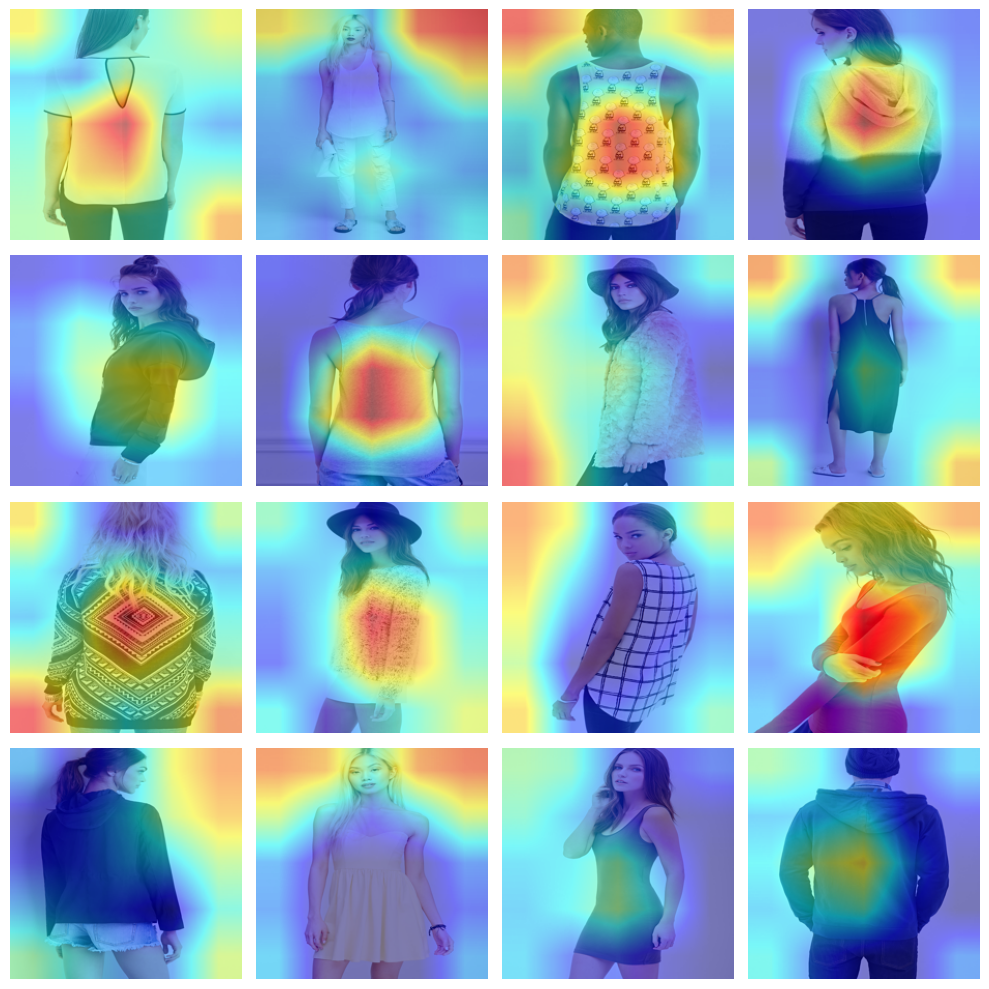

In [39]:
num_rows = 4
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through the images and display them on the grid
for i, image in enumerate(grad_cam_imgs):
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels

# Show the grid of images
plt.tight_layout()
plt.show()